In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
print(tf.__version__)
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

#plt.rcParams['figure.figsize'] = (12, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from DSAnalysis import CleanUp, JobAnalysis
from tqdm import tqdm

2.0.0


# Supplementary Functions

In [37]:
cu = CleanUp()

def encode_idxs(txt):
    
    """
    Converts each token/word into the corresponding index in 
    the vocabulary list in vocab.txt.
    
    :param txt: (String) Job listing text
    
    :return idxs: (List) of indicies
    """
    
    idxs = []
    
    for word in word_tokenize(txt):
        try:
            idxs.append(vocab.index(word))
        except:
            idxs.append(vocab.index("UNK"))
            
        
    return idxs

def clean_listing(txt, s_tokenize = True):
    
    """
    Cleans job listing text. The cleaning process includes
    removing stopwords and punctuation.
    
    :param filename: (String) job listing text file
    :param s_tokenize: (Boolean) perform sentence tokenisation. 
    This process should be true when preparing the text for 
    model prediction.
    """
    txt = cu.clean_text(txt, s_tokenize)
    return txt

# Plotting Settings

In [67]:
from matplotlib.colors import LinearSegmentedColormap

myColors = ((237,248,251, 1.0),
            (179,205,227, 1.0),
            (140,150,198, 1.0),
           (136,86,167, 1.0),
           (129,15,124, 1.0))
myColors = np.array(myColors)
myColors[:, :-1] /= 255.0
myColors = list(myColors)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# Data Input

Copy the job listing text and paste this within the "" and run the cell.  

In [32]:
txt = """This is an example job listing."""

# Commercial Experience Prediction

## Data Preprocessing

1. Encoding words in job listing into indicies. Words which do not appear in the training data vocabulary are encoded with the unknown flag (UNK). Numbers are encoded by the DIGIT flag. This allows for model to encode words not present in the training set and classify the sentences within the job listing.
2. Padding sequences of indicies into sequences of a consistent length.

In [49]:
# 1)
# Vocabulary which has appeared in training set.
vocab = open("vocab.txt").read().splitlines()

"""Words which will be assigned the unknown flag (UNK)
This will allow the model to classify any sentence,
whether it has observed every word in it or no.t"""
unk_words = pd.read_csv("UNK_flag.csv", index_col = 0)
# Applied 50th percentile over word counts as UNK flag
unk_words = list(unk_words["word"].values)

unk_words = unk_words + list(set(word_tokenize(txt)) - set(vocab))

print("Number of unknown words: {}".format(len(unk_words)))
print("Number of vocab words: {}".format(len(vocab)))

In [50]:
# 2)
# Converting the text into sequential data for the model

X = clean_listing(txt, s_tokenize = True)

data = pd.DataFrame({"sentence": X})
data.loc[:, "desc"] = "job_listing"

# Making the text sequences the same length for the purpose of prediction.

seq = [encode_idxs(txt) for txt in data["sentence"]] 
X = tf.keras.preprocessing.sequence.pad_sequences(seq)

## Model Specifications

In [53]:
model = tf.keras.models.load_model('b-relations.h5')
model.summary()

In [ ]:
# Model Predictions

predictions = model.predict(X)

predictions = np.argmax(predictions, axis = 1)

data.loc[:, "Predicted Classes"] = predictions

data

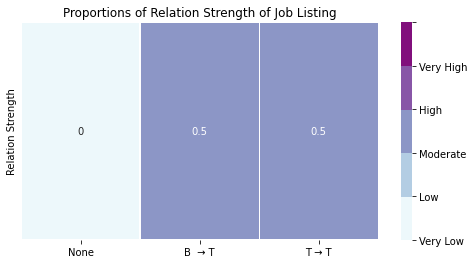

In [80]:
# Preparing predictions for visualisation

desc_relations = data.groupby(["desc", "Predicted Classes"]).size()
desc_relations = pd.DataFrame(desc_relations / desc_relations.groupby(level=0).sum()).reset_index()

relation_viz = np.zeros(3)
for i in desc_relations.iterrows():
    relation_viz[i[1]["Predicted Classes"]] += i[1][0]

# Plotting proportions of relation strength 

plt.figure(figsize = (8,4))
ax = sns.heatmap(relation_viz.reshape(-1, 1).T, annot = True, linewidths = .5, cmap = cmap, vmax = 1.0)

# Discretizing relation strength by the following
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 0.2, 0.4 , 0.6 ,0.8 , 1.0])
colorbar.set_ticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Plot features
plt.title("Proportions of Relation Strength of Job Listing")
plt.ylabel("Relation Strength")
plt.yticks([],[])
plt.xticks([.5,1.5,2.5], ["None", "B  → T", "T → T"])
plt.show()

# Skills Match

Run the cell below to populate the dictionary with skills that you have and do not have which frequently appear in the LinkedIn dataset.

In [27]:
# If you have the skill, change the 0 to a 1.
my_skills = {}
skills = open("skills.txt").read().splitlines()

print("If you have the skill, type 1 and ENTER. If not type 0 and ENTER")
for s in tqdm(skills):
    have_skill = 2
    while have_skill < 0 or have_skill > 1:
        try:
            have_skill = int(input("{}: ".format(s)))
        except:
            print("Please type in 0 or 1 as a response.")
            print("0 : Do not have the skill.")
            print("1 : Do have the skill")
            have_skill = 2 
    my_skills[s] = have_skill
    

  0%|          | 0/10 [00:00<?, ?it/s]

If you have the skill, type 1 and ENTER. If not type 0 and ENTER
ai: 1


 10%|█         | 1/10 [00:04<00:39,  4.41s/it]

algebra : 1


 20%|██        | 2/10 [00:04<00:25,  3.18s/it]

algorithm : 1


 30%|███       | 3/10 [00:04<00:16,  2.30s/it]

algorithmic : 1


 40%|████      | 4/10 [00:05<00:10,  1.68s/it]

algorithms : 1


 50%|█████     | 5/10 [00:05<00:06,  1.24s/it]

algorithmsmodels : 1


 60%|██████    | 6/10 [00:05<00:03,  1.01it/s]

analyse : 1


 70%|███████   | 7/10 [00:06<00:02,  1.23it/s]

analyses : 1


 80%|████████  | 8/10 [00:06<00:01,  1.50it/s]

analysing : 
Please type in 0 or 1 as a response.
0 : Do not have the skill.
1 : Do have the skill
analysing : 1


 90%|█████████ | 9/10 [00:08<00:00,  1.02it/s]

analysis : 1


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Run the following cell to compute the Job Listing Content (JLC) skills match 

In [31]:
my_skills = pd.DataFrame(my_skills, index = [0]).T.reset_index()
my_skills.columns = ["Skills", "Skills I have"]
my_skills["Skills I have"] = np.where(my_skills["Skills I have"] == 0, np.nan, 1)

j = JobAnalysis(my_skills)


c_text = cu.clean_text(txt, s_tokenize = False)
skills_match = j.skills_match(c_text)

print("Skills match with the job listing: {}%".format(skills_match * 100))

1 1
Skills match with the job listing: 100.0%
